# XGBoost Most Important Features

In [45]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/unemployment_data.csv')
data.head()

,initclaims_rate_regular,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% households wo car,Number of Hospitals,% disabled,% Without Health Insurance,% Limited English Proficiency,% workers commuting by public transit,% Veterans in Civilian Adult Population,opioid death rate,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,26.0512,1001,Alabama,Autauga,791.0,8128.591190,20.882987,4.743889,4.654031,8.619529,...,0.056569,1.0,19.3,10.0,0.653564,0.1,12.283,8.992644,0,2527
1,30.8648,1003,Alabama,Baldwin,2967.0,7354.122530,17.509134,4.224519,4.304056,8.345003,...,0.035530,4.0,14.0,13.2,1.424538,0.1,11.938,6.421370,0,1787
2,24.5891,1005,Alabama,Barbour,472.0,10253.573403,29.591802,5.430279,5.185594,11.474559,...,0.092373,1.0,22.2,13.5,1.469628,0.3,7.672,20.095655,0,1914
3,35.7501,1007,Alabama,Bibb,471.0,11977.539484,19.439724,4.591482,4.551699,10.308710,...,0.059283,1.0,16.7,10.6,0.687135,0.5,7.152,22.321429,0,896
4,15.1614,1009,Alabama,Blount,1085.0,11335.071134,21.745293,4.860808,4.891455,7.604563,...,0.041373,1.0,14.2,14.1,1.461165,0.1,8.532,8.644537,0,4449


In [3]:
X = data.drop(["FIPS", "initclaims_rate_regular", "State", "County"], axis=1)
y = pd.DataFrame(data["initclaims_rate_regular"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
len(X.columns)

92

## Dummy Baseline

In [8]:
y_train_mean = y_train.mean()
y_train_mean

initclaims_rate_regular    35.438391
dtype: float64

In [9]:
(((y_test - y_train_mean)**2).sum())**(.5)

initclaims_rate_regular    328.317688
dtype: float64

## XGBoost and Feature Importance

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [14]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [15]:
num_boost_round = 999

In [16]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:28.22218
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:21.58318
[2]	Test-rmse:17.70608
[3]	Test-rmse:15.35037
[4]	Test-rmse:14.01921
[5]	Test-rmse:13.15437
[6]	Test-rmse:12.82326
[7]	Test-rmse:12.87895
[8]	Test-rmse:12.75560
[9]	Test-rmse:12.77038
[10]	Test-rmse:12.67193
[11]	Test-rmse:12.64893
[12]	Test-rmse:12.75393
[13]	Test-rmse:12.80525
[14]	Test-rmse:12.79372
[15]	Test-rmse:12.73014
[16]	Test-rmse:12.73780
[17]	Test-rmse:12.71751
[18]	Test-rmse:12.70771
[19]	Test-rmse:12.71625
[20]	Test-rmse:12.70175
[21]	Test-rmse:12.71401
Stopping. Best iteration:
[11]	Test-rmse:12.64893



In [17]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,31.852321,0.640213,33.125367,3.110191
1,24.346380,0.561955,27.334533,3.648767
2,19.085916,0.494991,23.598719,3.939532
3,15.216101,0.413400,21.373313,3.955512
4,12.374151,0.330116,20.149808,3.999664
5,10.296240,0.232084,19.637870,4.016703
6,8.798888,0.183067,19.267147,4.000660
7,7.634723,0.227047,18.942960,3.771833
8,6.667251,0.208420,18.842869,3.681327
9,5.878869,0.171504,18.801785,3.632799


In [18]:
cv_results['test-rmse-mean'].min()

18.581645599999998

### Tune max_depth and min_child_weight

In [19]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [20]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 18.6708938 for 15 rounds
CV with max_depth=9, min_child_weight=6
	rmse 18.402519599999998 for 11 rounds
CV with max_depth=9, min_child_weight=7
	rmse 18.3291884 for 12 rounds
CV with max_depth=10, min_child_weight=5
	rmse 18.764783599999998 for 10 rounds
CV with max_depth=10, min_child_weight=6
	rmse 18.3258764 for 12 rounds
CV with max_depth=10, min_child_weight=7
	rmse 18.1889052 for 12 rounds
CV with max_depth=11, min_child_weight=5
	rmse 18.419418 for 18 rounds
CV with max_depth=11, min_child_weight=6
	rmse 18.425879799999997 for 18 rounds
CV with max_depth=11, min_child_weight=7
	rmse 18.481814399999998 for 11 rounds
Best params: 10, 7, rmse: 18.1889052


In [21]:
params['max_depth'] = 10
params['min_child_weight'] = 7

### Tune subsample and colsample

In [22]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [23]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 18.188905 for 12 rounds
CV with subsample=1.0, colsample=0.9
	rmse 18.6997312 for 12 rounds
CV with subsample=1.0, colsample=0.8
	rmse 18.1181332 for 14 rounds
CV with subsample=1.0, colsample=0.7
	rmse 18.0447622 for 10 rounds
CV with subsample=0.9, colsample=1.0
	rmse 18.044535 for 9 rounds
CV with subsample=0.9, colsample=0.9
	rmse 18.673950400000003 for 9 rounds
CV with subsample=0.9, colsample=0.8
	rmse 18.468635 for 25 rounds
CV with subsample=0.9, colsample=0.7
	rmse 18.303140000000003 for 14 rounds
CV with subsample=0.8, colsample=1.0
	rmse 18.8807062 for 21 rounds
CV with subsample=0.8, colsample=0.9
	rmse 18.530993400000003 for 10 rounds
CV with subsample=0.8, colsample=0.8
	rmse 18.0714064 for 10 rounds
CV with subsample=0.8, colsample=0.7
	rmse 18.5290278 for 10 rounds
CV with subsample=0.7, colsample=1.0
	rmse 18.7254508 for 12 rounds
CV with subsample=0.7, colsample=0.9
	rmse 18.730409 for 9 rounds
CV with subsample=0.7, colsampl

In [24]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0

### Tune eta

In [25]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 18.0445352 for 9 rounds

CV with eta=0.2
	rmse 17.646705 for 16 rounds

CV with eta=0.1
	rmse 17.685001200000002 for 46 rounds

CV with eta=0.05
	rmse 17.4223462 for 87 rounds

CV with eta=0.01
	rmse 17.2786896 for 456 rounds

CV with eta=0.005
	rmse 17.2932076 for 846 rounds

Best params: 0.01, rmse: 17.2786896


In [26]:
params['eta'] = .01

In [27]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:37.51494
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:37.18546
[2]	Test-rmse:36.85728
[3]	Test-rmse:36.52485
[4]	Test-rmse:36.19713
[5]	Test-rmse:35.88445
[6]	Test-rmse:35.57399
[7]	Test-rmse:35.25361
[8]	Test-rmse:34.94605
[9]	Test-rmse:34.63640
[10]	Test-rmse:34.33488
[11]	Test-rmse:34.02325
[12]	Test-rmse:33.71927
[13]	Test-rmse:33.42431
[14]	Test-rmse:33.12648
[15]	Test-rmse:32.85965
[16]	Test-rmse:32.58029
[17]	Test-rmse:32.29669
[18]	Test-rmse:32.01305
[19]	Test-rmse:31.72859
[20]	Test-rmse:31.46905
[21]	Test-rmse:31.20089
[22]	Test-rmse:30.94474
[23]	Test-rmse:30.67909
[24]	Test-rmse:30.42026
[25]	Test-rmse:30.16609
[26]	Test-rmse:29.91900
[27]	Test-rmse:29.67697
[28]	Test-rmse:29.42204
[29]	Test-rmse:29.17960
[30]	Test-rmse:28.94236
[31]	Test-rmse:28.70657
[32]	Test-rmse:28.46165
[33]	Test-rmse:28.22454
[34]	Test-rmse:27.99314
[35]	Test-rmse:27.76304
[36]	Test-rmse:27.54083
[37]	Test-rmse:27.31915
[38]	Test-rmse:27.10037
[39]	Test-rmse:26

In [28]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 11.81 in 271 rounds


### Get and save best model

In [29]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:37.51494
[1]	Test-rmse:37.18546
[2]	Test-rmse:36.85728
[3]	Test-rmse:36.52485
[4]	Test-rmse:36.19713
[5]	Test-rmse:35.88445
[6]	Test-rmse:35.57399
[7]	Test-rmse:35.25361
[8]	Test-rmse:34.94605
[9]	Test-rmse:34.63640
[10]	Test-rmse:34.33488
[11]	Test-rmse:34.02325
[12]	Test-rmse:33.71927
[13]	Test-rmse:33.42431
[14]	Test-rmse:33.12648
[15]	Test-rmse:32.85965
[16]	Test-rmse:32.58029
[17]	Test-rmse:32.29670
[18]	Test-rmse:32.01305
[19]	Test-rmse:31.72859
[20]	Test-rmse:31.46905
[21]	Test-rmse:31.20089
[22]	Test-rmse:30.94474
[23]	Test-rmse:30.67909
[24]	Test-rmse:30.42026
[25]	Test-rmse:30.16609
[26]	Test-rmse:29.91900
[27]	Test-rmse:29.67697
[28]	Test-rmse:29.42204
[29]	Test-rmse:29.17960
[30]	Test-rmse:28.94236
[31]	Test-rmse:28.70657
[32]	Test-rmse:28.46165
[33]	Test-rmse:28.22454
[34]	Test-rmse:27.99314
[35]	Test-rmse:27.76304
[36]	Test-rmse:27.54083
[37]	Test-rmse:27.31915
[38]	Test-rmse:27.10037
[39]	Test-rmse:26.87612
[40]	Test-rmse:26.66418
[41]	Test-rmse:26.45509
[4

In [30]:
best_model.save_model("my_model.model")

In [33]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

11.80995964705711

### Feature Importance

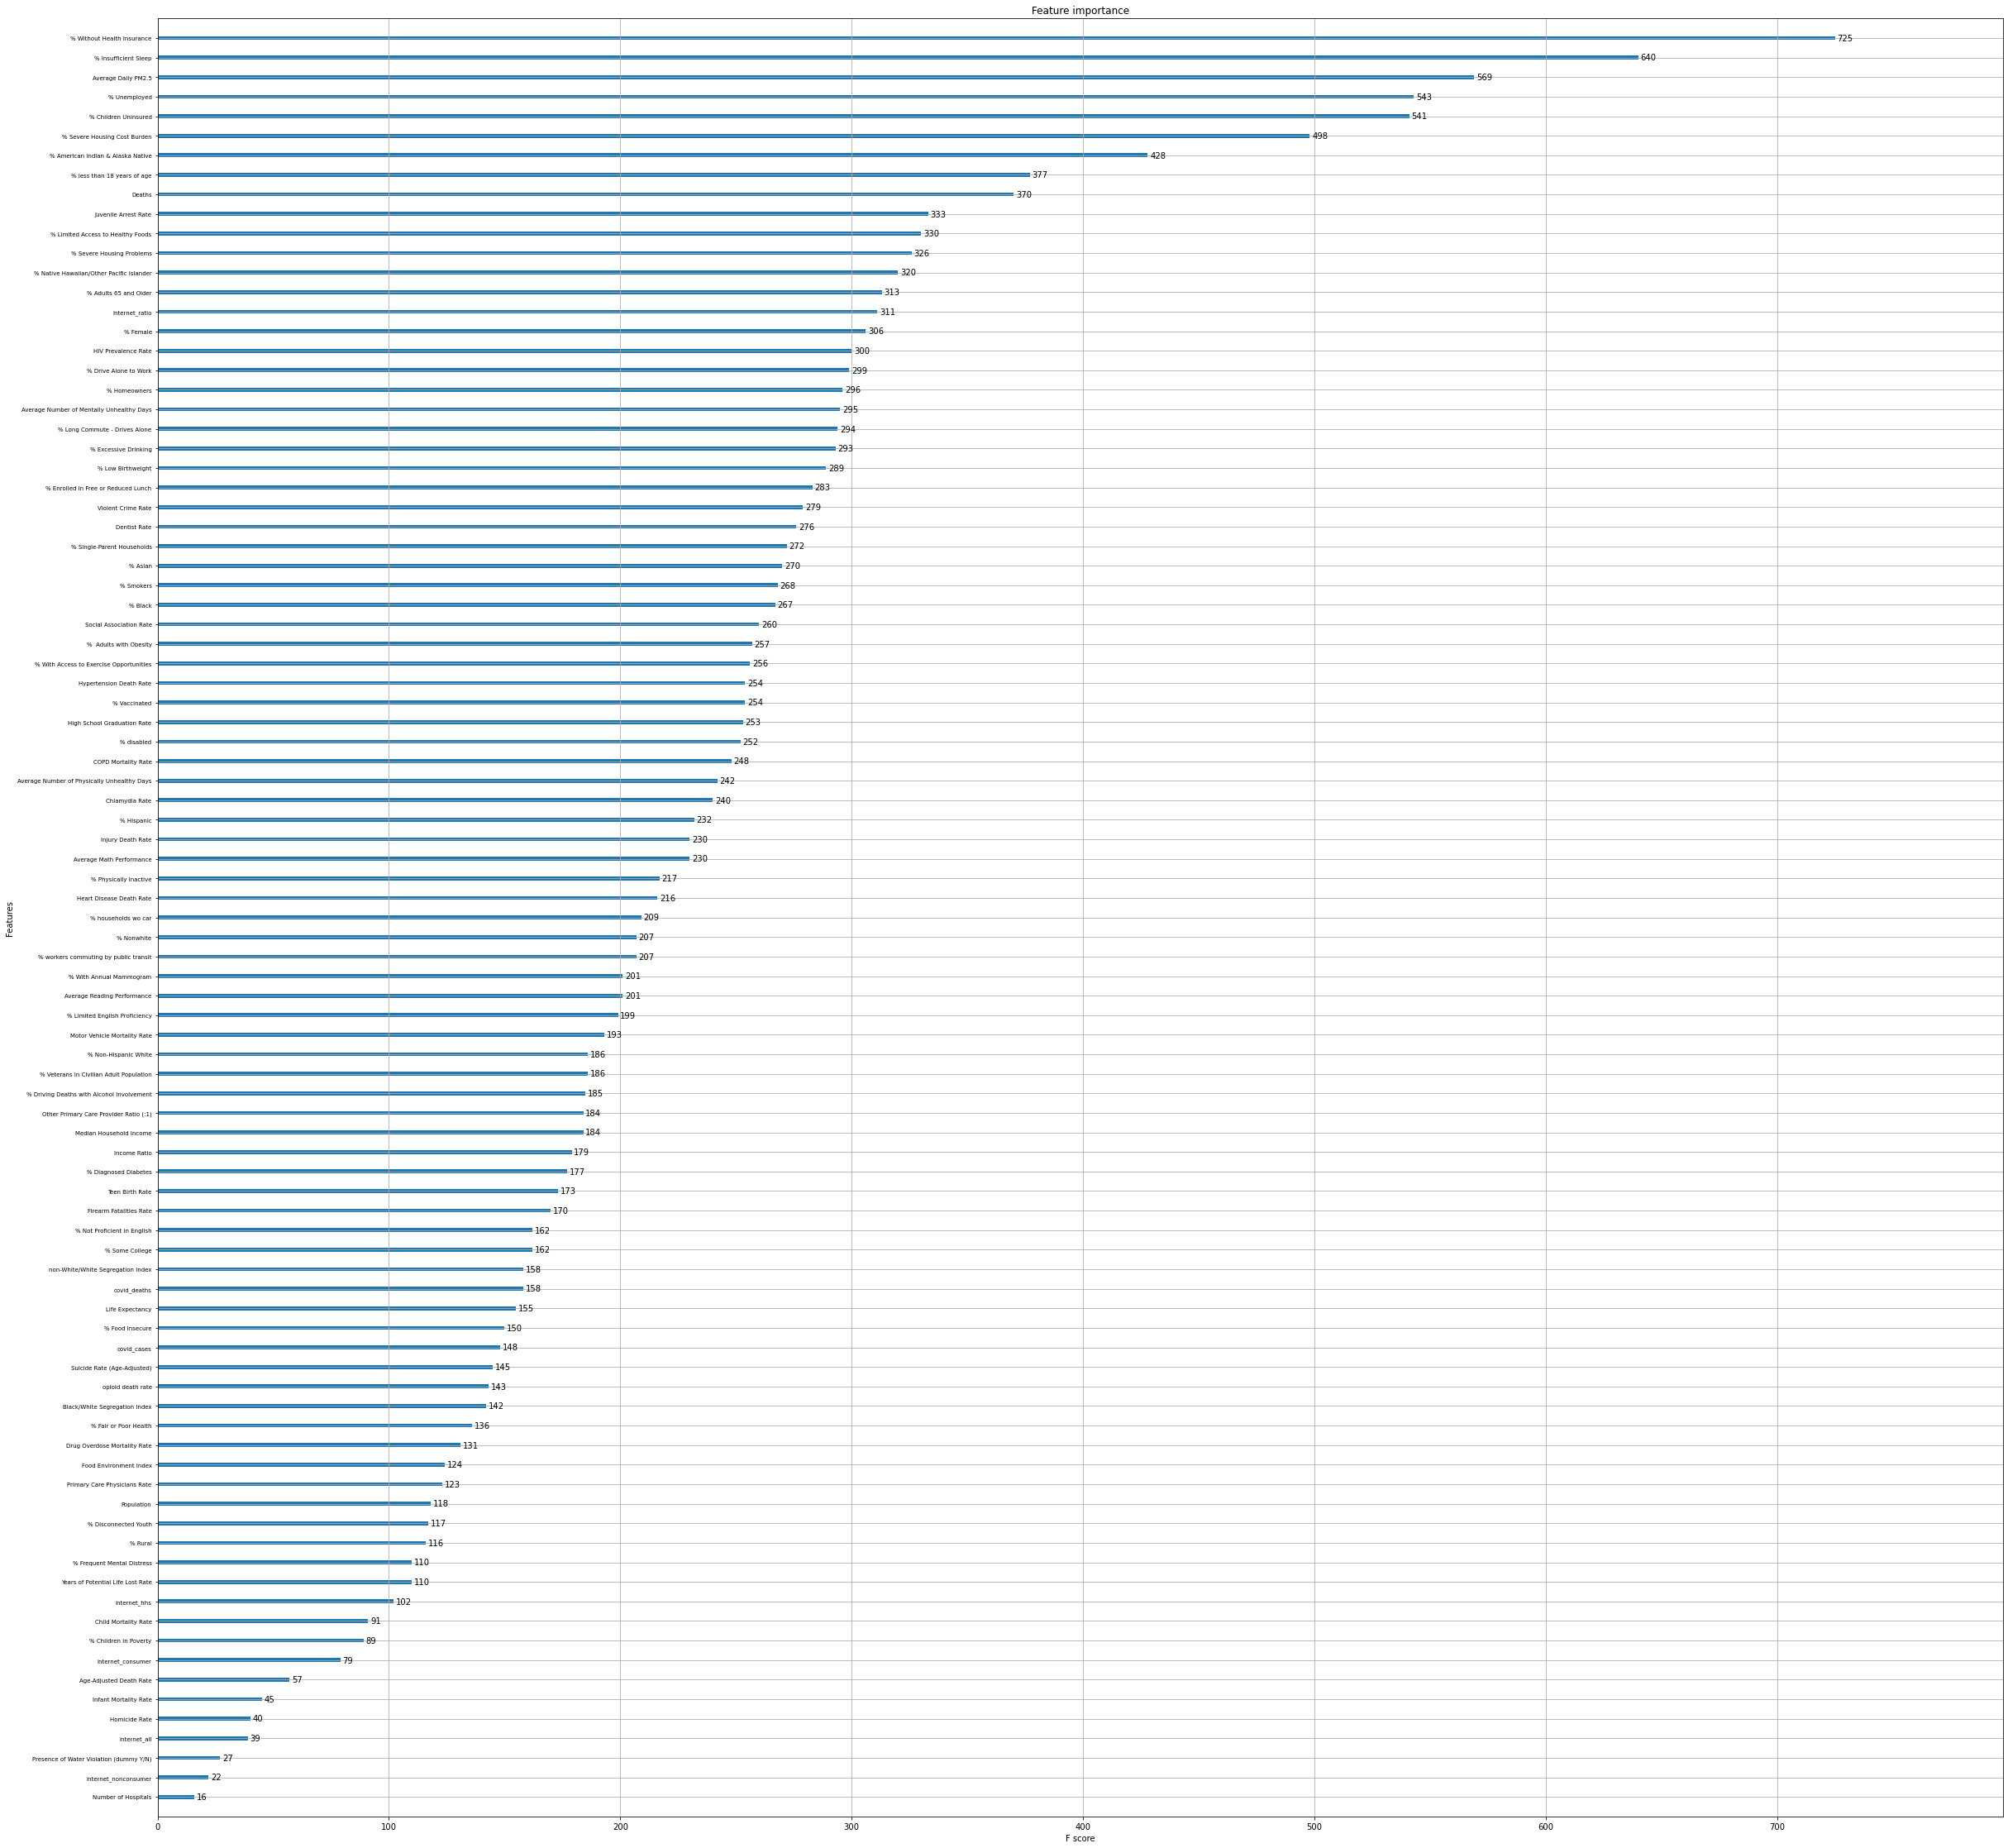

In [37]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 9 most important features (F-score > 350):
1. % Without Health Insurance
2. % Insufficient Sleep
3. Average Daily PM2.5
4. % Unemployed
5. % Children Uninsured
6. % Severe Housing Cost Burden
7. % American Indian & Alaska Native
8. % less than 18 years of age
9. Deaths

### Correlation

In [39]:
X_x = X.filter(['% Without Health Insurance', '% Insufficient Sleep', 'Average Daily PM2.5', 
               '% Unemployed', '% Children Uninsured', '% Severe Housing Cost Burden', 
               '% American Indian & Alaska Native', '% less than 18 years of age', 'Deaths'])

In [41]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,% Without Health Insurance,% Insufficient Sleep,Average Daily PM2.5,% Unemployed,% Children Uninsured,% Severe Housing Cost Burden,% American Indian & Alaska Native,% less than 18 years of age,Deaths
% Without Health Insurance,1.000000,0.144063,0.082438,0.007623,0.696057,0.099834,0.125784,0.182563,0.082104
% Insufficient Sleep,0.144063,1.000000,0.498231,0.456242,0.099977,0.280545,0.051507,0.044160,0.118638
Average Daily PM2.5,0.082438,0.498231,1.000000,0.201776,0.281111,0.025061,0.228401,0.171206,0.189813
% Unemployed,0.007623,0.456242,0.201776,1.000000,0.173985,0.280966,0.147859,0.123555,0.024574
% Children Uninsured,0.696057,0.099977,0.281111,0.173985,1.000000,0.131762,0.118926,0.106671,0.146340
% Severe Housing Cost Burden,0.099834,0.280545,0.025061,0.280966,0.131762,1.000000,0.021520,0.181727,0.360554
% American Indian & Alaska Native,0.125784,0.051507,0.228401,0.147859,0.118926,0.021520,1.000000,0.127595,0.007422
% less than 18 years of age,0.182563,0.044160,0.171206,0.123555,0.106671,0.181727,0.127595,1.000000,0.032619
Deaths,0.082104,0.118638,0.189813,0.024574,0.146340,0.360554,0.007422,0.032619,1.000000


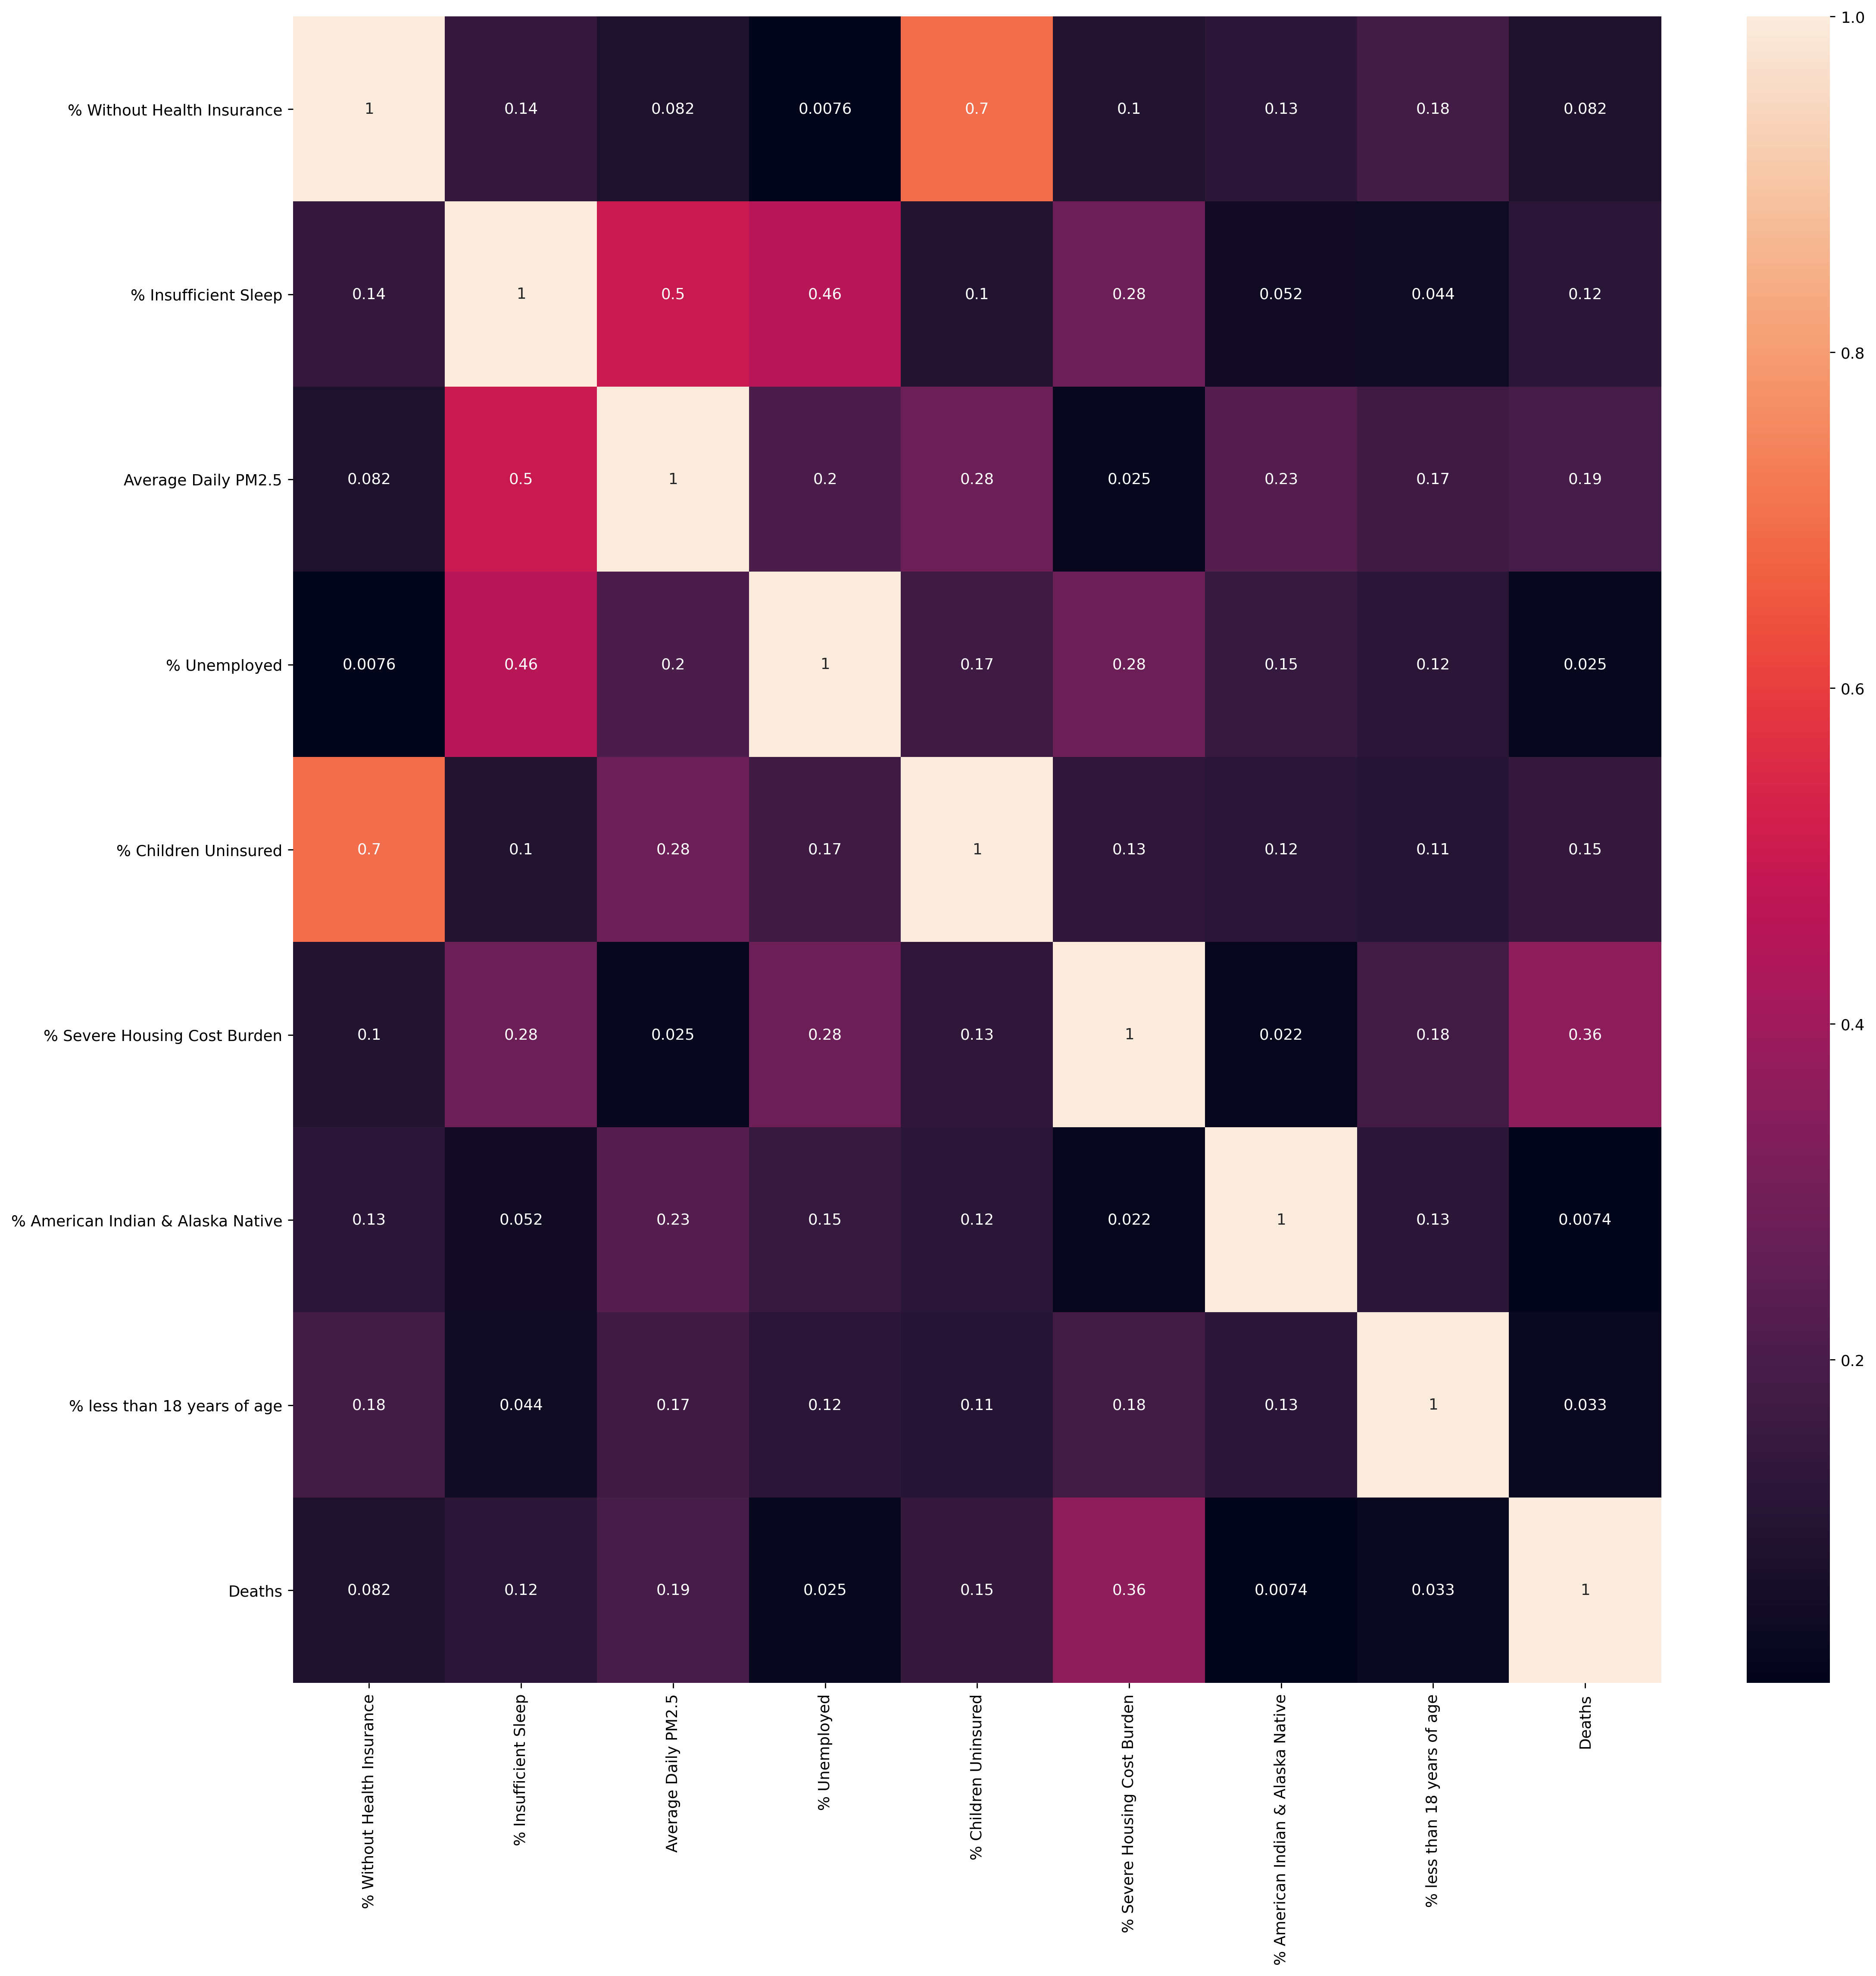

In [44]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

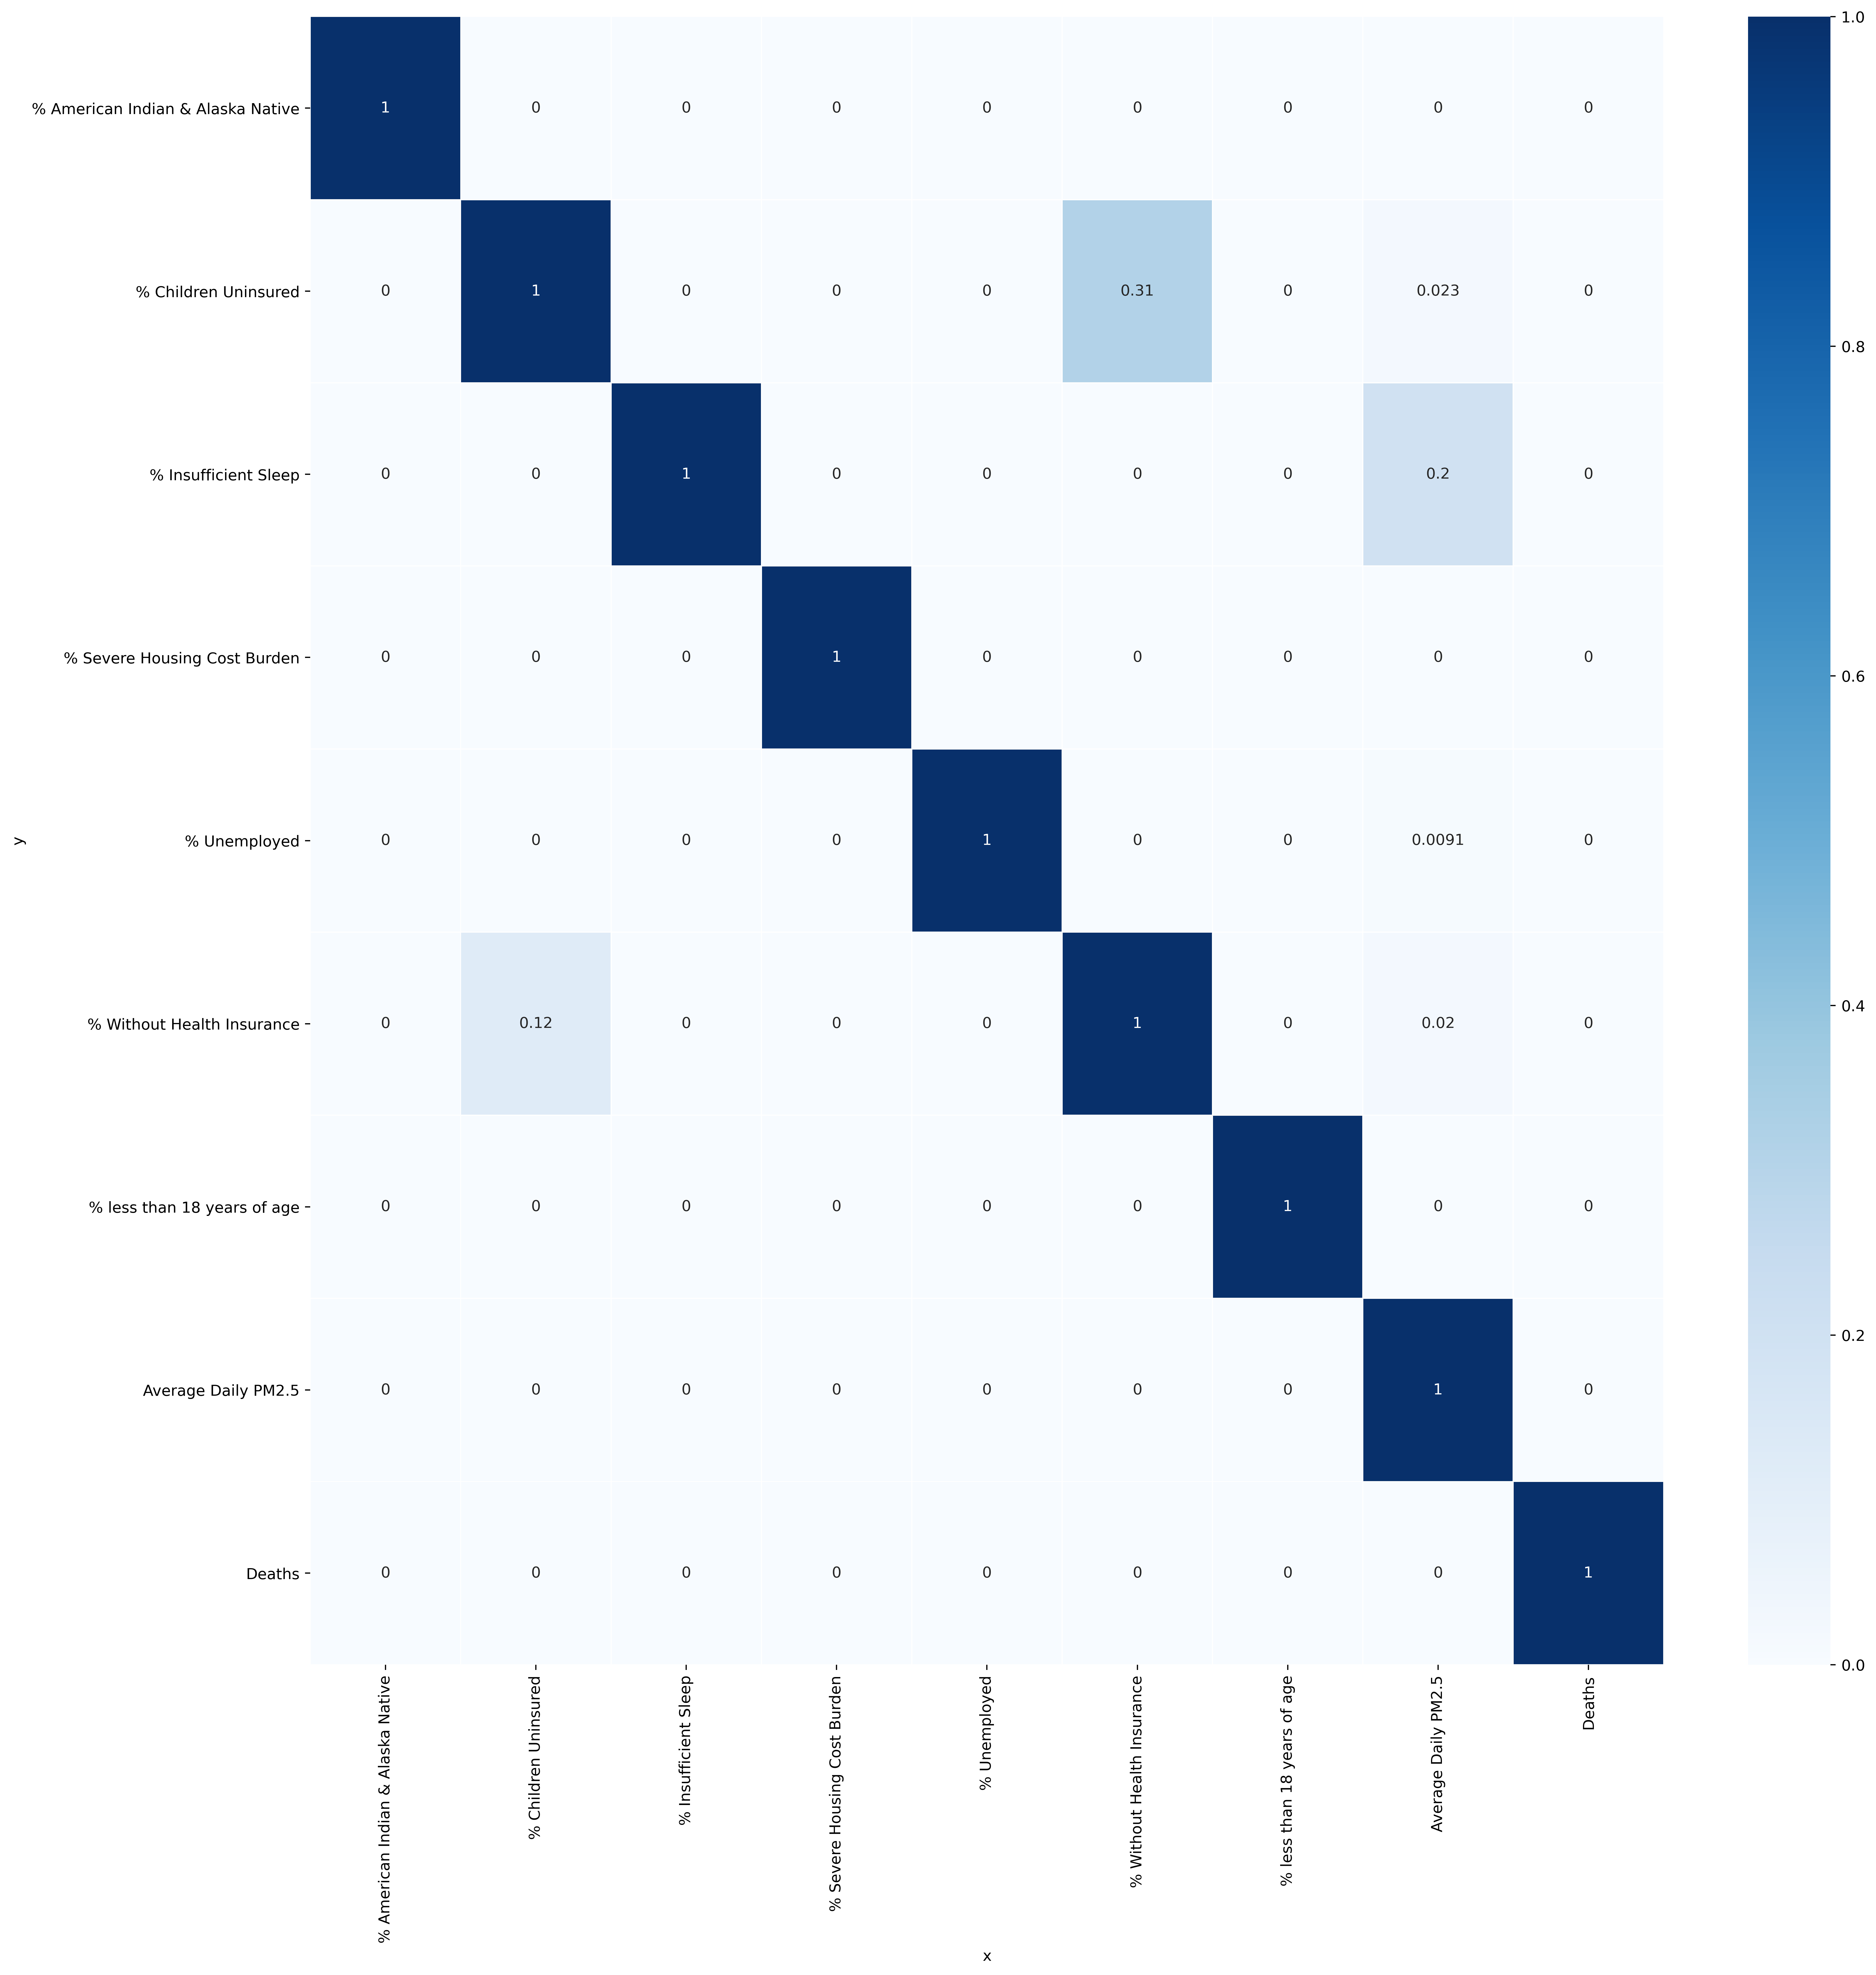

In [47]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()